# PCA Analyse

## Ergebnisse auslesen

In [1]:
import pandas as pd
import numpy as np
from src import plot
import os
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

In [2]:
# Speicherort der Dateien
directory = "data/PCA/"
component_counts = [
    10, 
    20, 
    30, 
    40
]  # Die verschiedenen Hauptkomponentenanzahlen

# Leere Dictionaries, um die Ergebnisse und Vorhersagen zu sammeln
all_results = {}
all_predictions = {}

# Iteriere über die Hauptkomponentenanzahlen
for num_components in component_counts:
    
    metrics_file = os.path.join(directory, f"{num_components}_PCA_metrics.csv")
    predictions_file = os.path.join(directory, f"{num_components}_PCA_predictions.csv")
    
    # Einlesen der CSV-Dateien
    metrics_df = pd.read_csv(metrics_file)
    predictions_df = pd.read_csv(predictions_file)
    
    # Füge eine Spalte für die Anzahl der Hauptkomponenten hinzu (falls gewünscht)
    metrics_df['Hauptkomponenten-Anzahl'] = num_components
    predictions_df['Hauptkomponenten-Anzahl'] = num_components
    
    # Ergebnisse (Metriken) in Dictionary umwandeln und speichern
    # Setze den Index der Metriken auf 'Model_name'
    metrics_df.set_index('Model_name', inplace=True)
    metrics_dict = metrics_df.to_dict(orient="index")
    
    # Speichere im Haupt-Results Dictionary unter der Hauptkomponentenanzahl
    if num_components not in all_results:
        all_results[num_components] = {}
    
    # Für jedes Modell die Metriken und die Hauptkomponenten in das all_results einfügen
    for model_name, metrics in metrics_dict.items():
        # Nimm die Hauptkomponenten als Numpy-Array (falls sie als String vorliegen, umwandeln)
        if isinstance(metrics['Hauptkomponenten'], str):
            metrics['Hauptkomponenten'] = np.fromstring(metrics['Hauptkomponenten'].strip('[]'), sep=' ')
        
        # Speichere das Modell mit den Metriken und den Hauptkomponenten
        all_results[num_components][model_name] = metrics
    
    # Vorhersagen in Dictionary umwandeln
    predictions_dict = {}
    for model_name in predictions_df['Model_name'].unique():
        model_data = {}
        model_df = predictions_df[predictions_df['Model_name'] == model_name]
        
        model_data['Model_name'] = model_name
        
        # Iteriere über die einzigartigen Datentypen im Modell
        for data_type in model_df['Data_type'].unique():
            values = model_df[model_df['Data_type'] == data_type]['Value'].values
            model_data[data_type] = values
        
        # Füge das Modelldaten-Dictionary zum Vorhersage-Dictionary hinzu
        predictions_dict[model_name] = model_data
    
    # Speichere im Haupt-Predictions Dictionary unter der Hauptkomponentenanzahl
    if num_components not in all_predictions:
        all_predictions[num_components] = {}
    
    all_predictions[num_components] = predictions_dict


In [3]:
evaluation = ['train', 'cv_train', 'cv_test', 'test']
selection_methode = "PCA"
MLA = [
    ('Linear Regressor',LinearRegression()),
    ('SVR', SVR(kernel='linear')),
    ('Random Forest',RandomForestRegressor()),
    ('Gradient Boosting', xgb.XGBRegressor())
]

# Analyse aller Durchläufe

## Erklärte Varianz und die Anzahl der Hauptkomponenten

[0, 10, 20, 30, 40] [0, 0.44836602000000003, 0.5890471900000002, 0.6707232100000001, 0.7255655600000002]


Text(0.5, 1.0, 'n_components vs. Explained Variance Ratio')

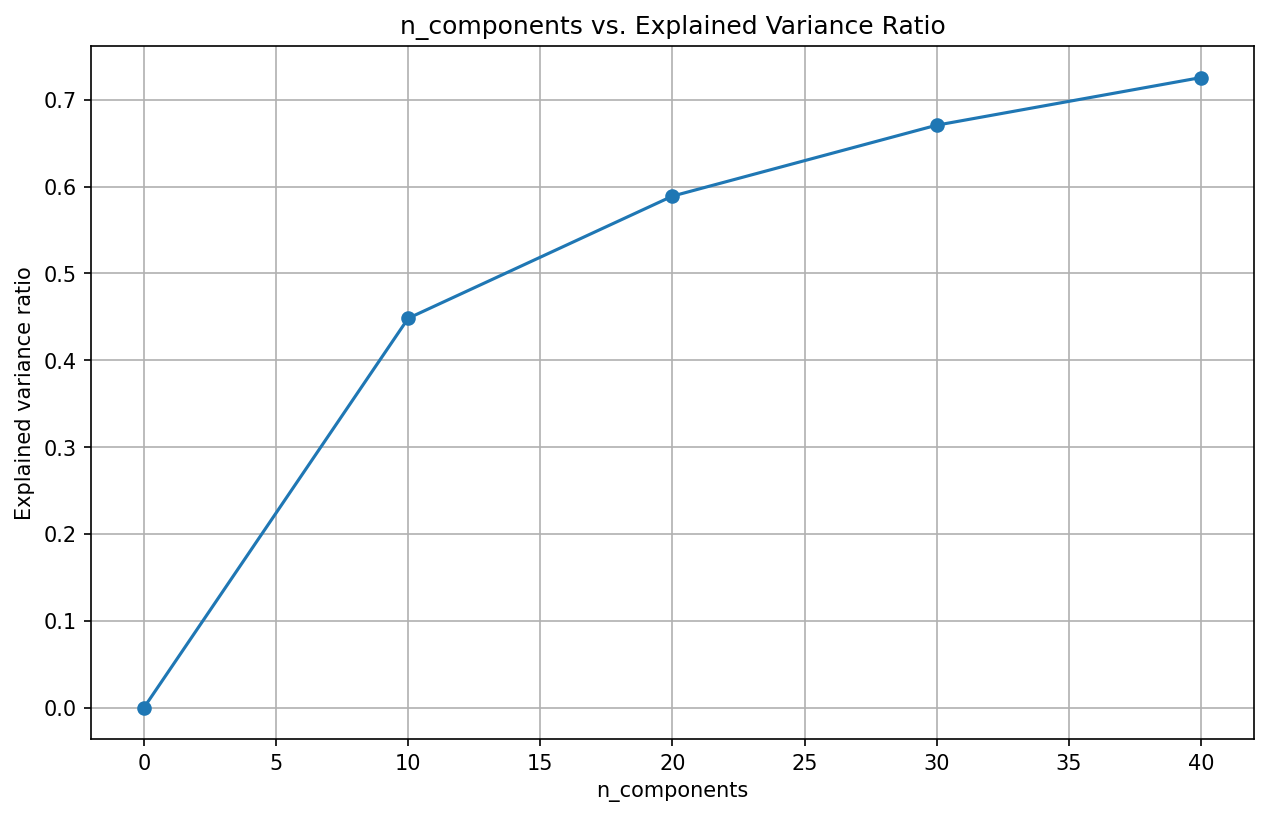

In [6]:
var_ratio = [0]
component_counts = [
    0,
    10, 
    20, 
    30, 
    40
]
for num_features, models in all_results.items():
    # Nehme die explained_ratio vom ersten Modell in der Liste
    first_model = next(iter(models.values()))
    var_ratio.append(sum(first_model['Hauptkomponenten']))

print(component_counts,var_ratio)
plt.figure(figsize=(10,6),dpi=150)
plt.grid()
plt.plot(component_counts,var_ratio,marker='o')
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')

## Metriken vs. Feature Anzahl

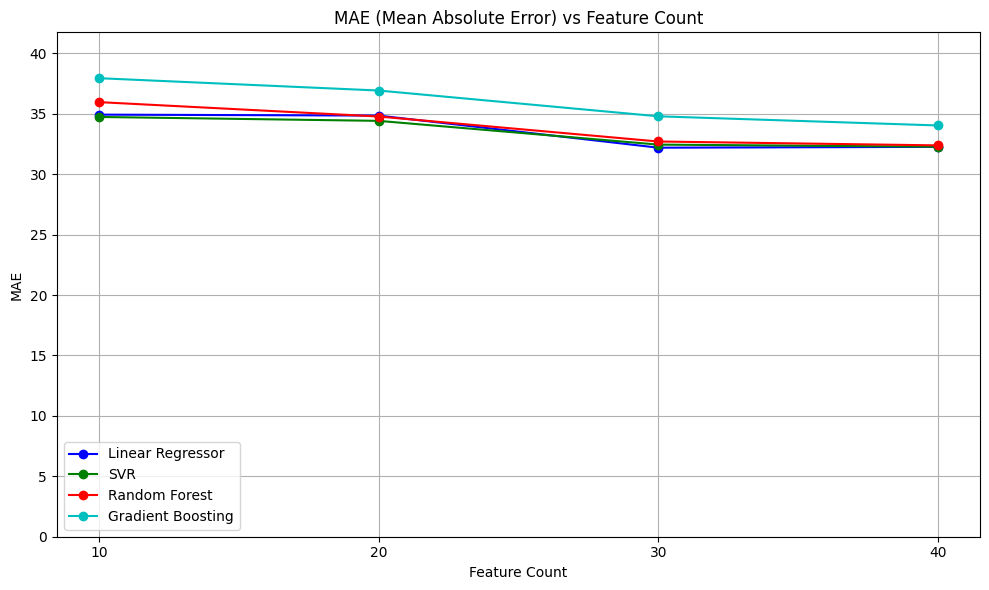

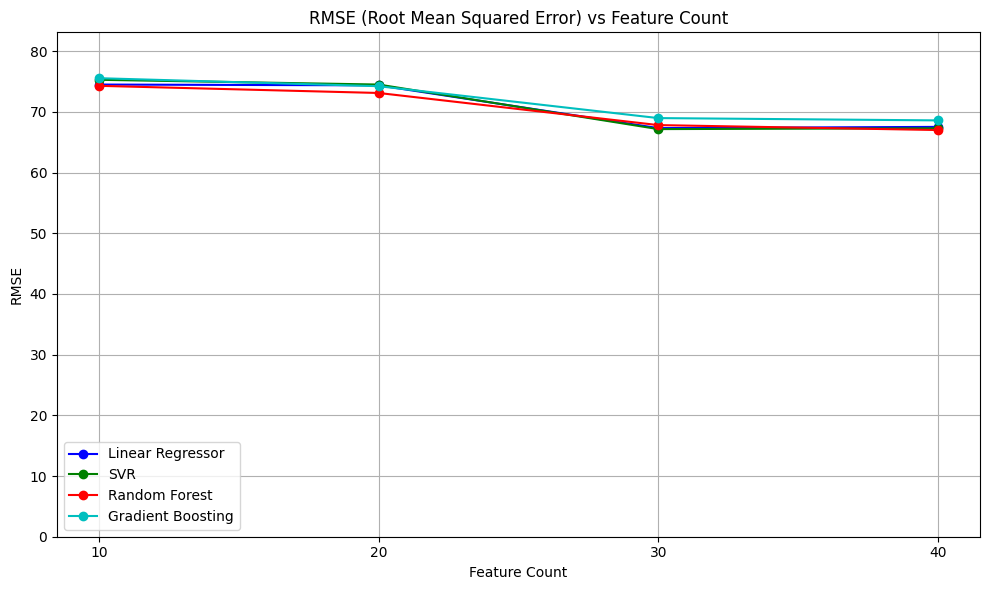

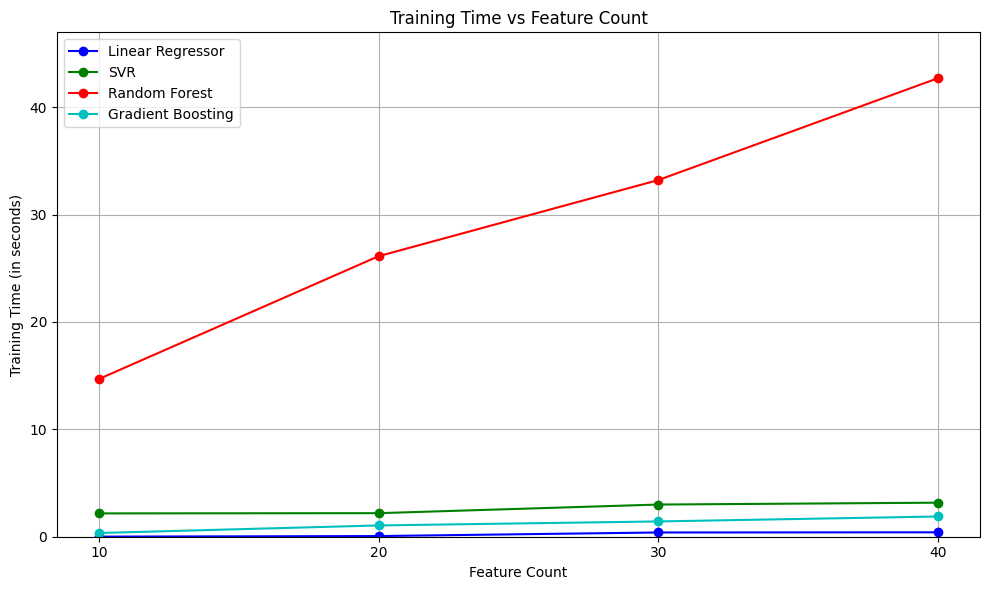

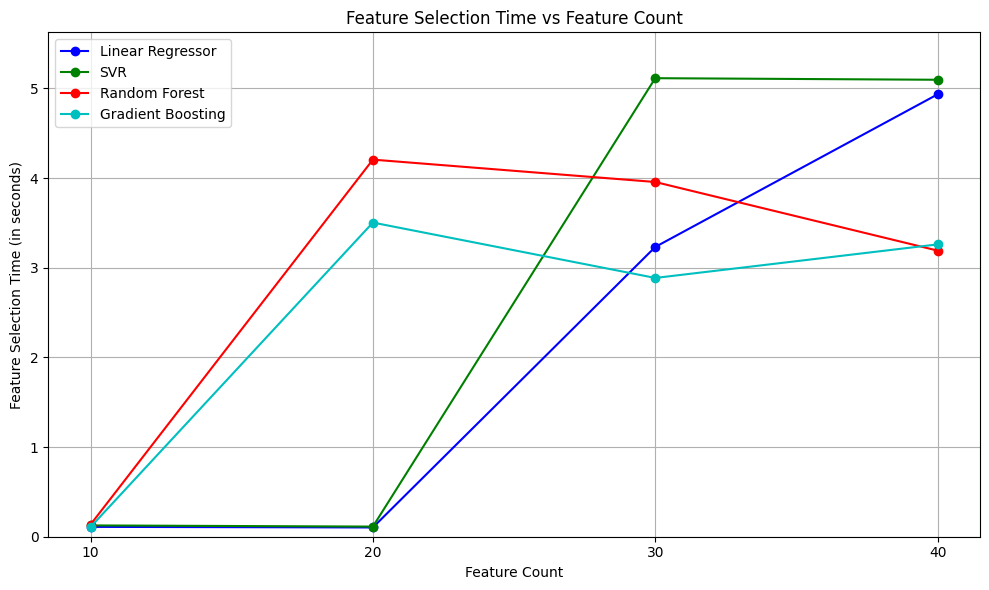

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Verzeichnis mit den gespeicherten Ergebnissen
output_dir = "data/PCA/"
save_path = "plots/PCA"

# Sicherstellen, dass der Ordner existiert, andernfalls erstellen
os.makedirs(save_path, exist_ok=True)

# Modellnamen und Farben für den Plot
models = ['Linear Regressor', 'SVR', 'Random Forest', 'Gradient Boosting']
colors = ['b', 'g', 'r', 'c']  # Farben für Modelle

# Listen, um die Metriken zu speichern
mae_values = {model: [] for model in models}
rmse_values = {model: [] for model in models}
train_time_values = {model: [] for model in models}  # Liste für Laufzeit
fs_time_values = {model: [] for model in models}  # Liste für Feature Selection Laufzeit
feature_counts = [10, 20, 30, 40]

# Iteriere über jede Feature-Anzahl und extrahiere die Metriken aus den CSV-Dateien
for num_features in feature_counts:
    # Pfad zur Metrik-Datei
    metrics_file = f'{output_dir}{num_features}_PCA_metrics.csv'
    
    # Lese die Metriken ein
    df_metrics = pd.read_csv(metrics_file)
    
    # Extrahiere die MAE, RMSE, Laufzeit und Feature Selection Laufzeit Werte für jedes Modell
    for model in models:
        mae_values[model].append(df_metrics.loc[df_metrics['Model_name'] == model, 'TestMAE'].values[0])
        rmse_values[model].append(df_metrics.loc[df_metrics['Model_name'] == model, 'TestRMSE'].values[0])
        train_time_values[model].append(df_metrics.loc[df_metrics['Model_name'] == model, 'TrainTime_ges'].values[0])  # Laufzeit
        fs_time_values[model].append(df_metrics.loc[df_metrics['Model_name'] == model, 'FS-Laufzeit'].values[0])  # FS Laufzeit

# Berechne den maximalen Wert für die Metriken MAE, RMSE, Laufzeit und FS Laufzeit, um die y-Achse dynamisch anzupassen
max_mae = max(max(mae_values[model]) for model in models)
max_rmse = max(max(rmse_values[model]) for model in models)
max_train_time = max(max(train_time_values[model]) for model in models)
max_fs_time = max(max(fs_time_values[model]) for model in models)

# Plot MAE
plt.figure(figsize=(10, 6))
for model, color in zip(models, colors):
    plt.plot(feature_counts, mae_values[model], label=model, color=color, marker='o')

# Achsen und Titel setzen
plt.title('MAE (Mean Absolute Error) vs Feature Count')
plt.xlabel('Feature Count')
plt.ylabel('MAE')
plt.xticks(feature_counts)
plt.ylim(0, max_mae * 1.1)  # Setze die y-Achse bei 0, mit etwas Platz über dem höchsten Wert
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'mae_vs_feature_count.png'))
plt.show()

# Plot RMSE
plt.figure(figsize=(10, 6))
for model, color in zip(models, colors):
    plt.plot(feature_counts, rmse_values[model], label=model, color=color, marker='o')

# Achsen und Titel setzen
plt.title('RMSE (Root Mean Squared Error) vs Feature Count')
plt.xlabel('Feature Count')
plt.ylabel('RMSE')
plt.xticks(feature_counts)
plt.ylim(0, max_rmse * 1.1)  # Setze die y-Achse bei 0, mit etwas Platz über dem höchsten Wert
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'rmse_vs_feature_count.png'))
plt.show()

# Plot Laufzeit
plt.figure(figsize=(10, 6))
for model, color in zip(models, colors):
    plt.plot(feature_counts, train_time_values[model], label=model, color=color, marker='o')

# Achsen und Titel setzen
plt.title('Training Time vs Feature Count')
plt.xlabel('Feature Count')
plt.ylabel('Training Time (in seconds)')
plt.xticks(feature_counts)
plt.ylim(0, max_train_time * 1.1)  # Setze die y-Achse bei 0, mit etwas Platz über dem höchsten Wert
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'train_time_vs_feature_count.png'))
plt.show()

# Plot Feature Selection Laufzeit
plt.figure(figsize=(10, 6))
for model, color in zip(models, colors):
    plt.plot(feature_counts, fs_time_values[model], label=model, color=color, marker='o')

# Achsen und Titel setzen
plt.title('Feature Selection Time vs Feature Count')
plt.xlabel('Feature Count')
plt.ylabel('Feature Selection Time (in seconds)')
plt.xticks(feature_counts)
plt.ylim(0, max_fs_time * 1.1)  # Setze die y-Achse bei 0, mit etwas Platz über dem höchsten Wert
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'fs_time_vs_feature_count.png'))
plt.show()

# Einzelnen Durchlauf analysieren

## Scatterplots Predictions

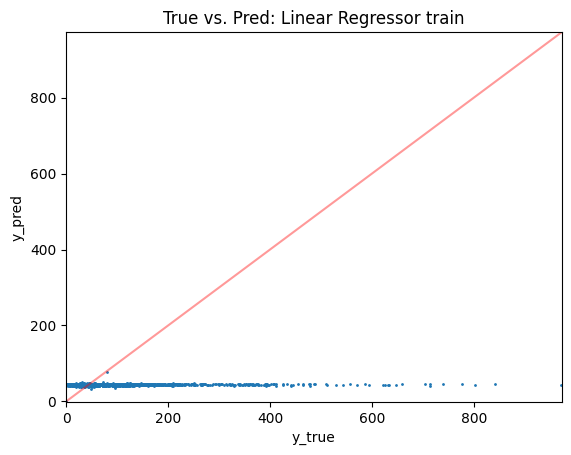

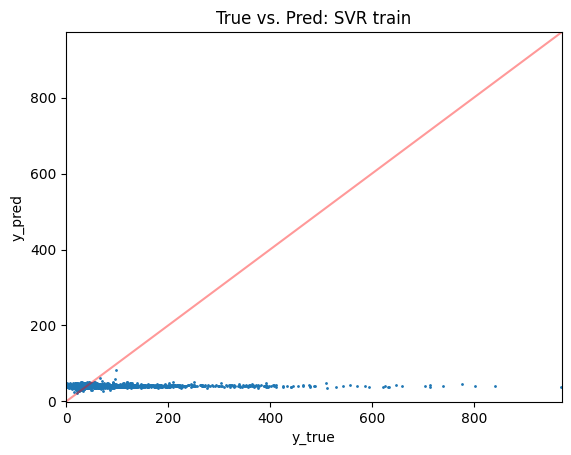

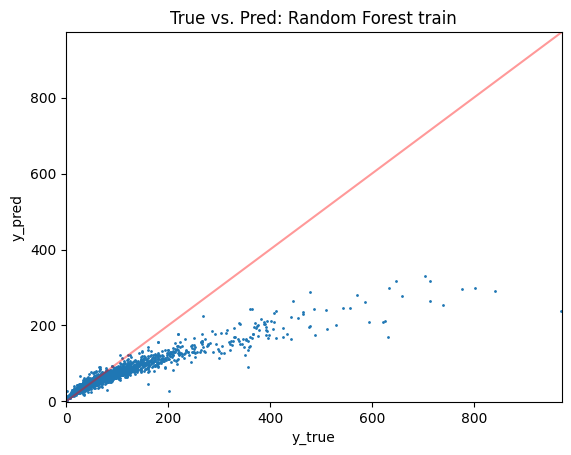

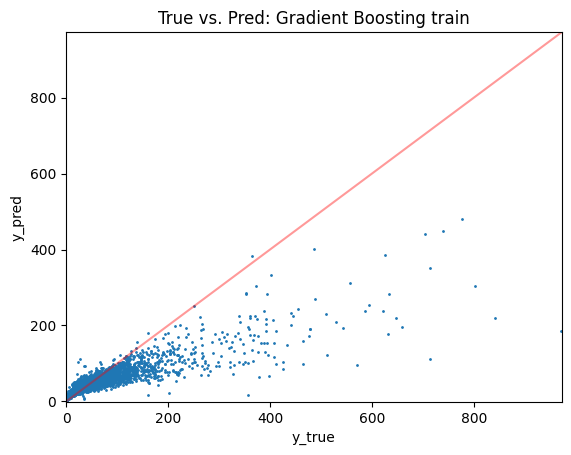

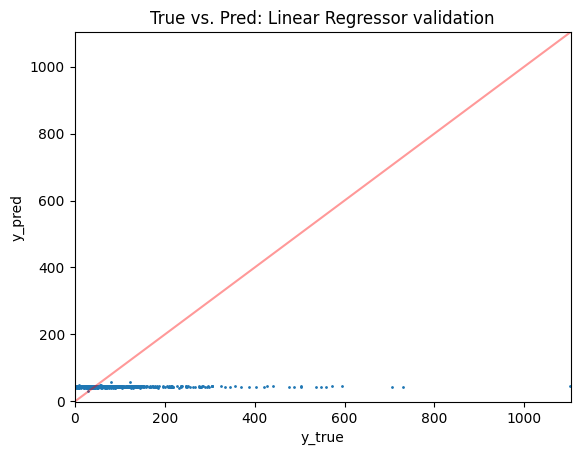

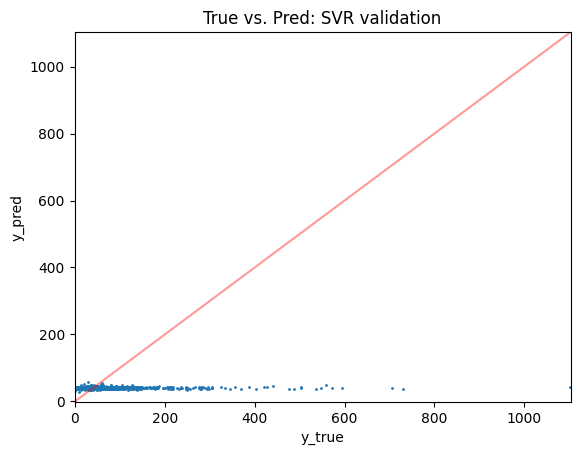

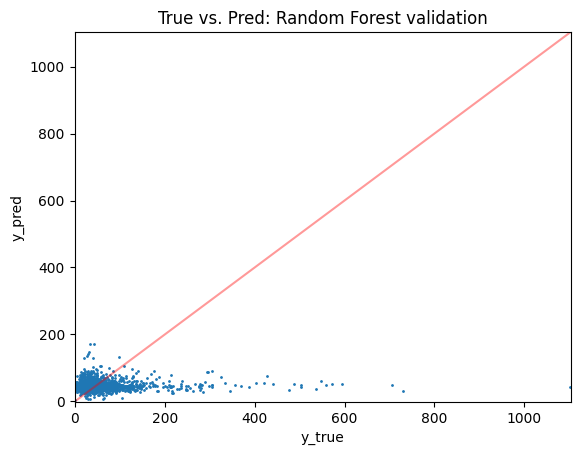

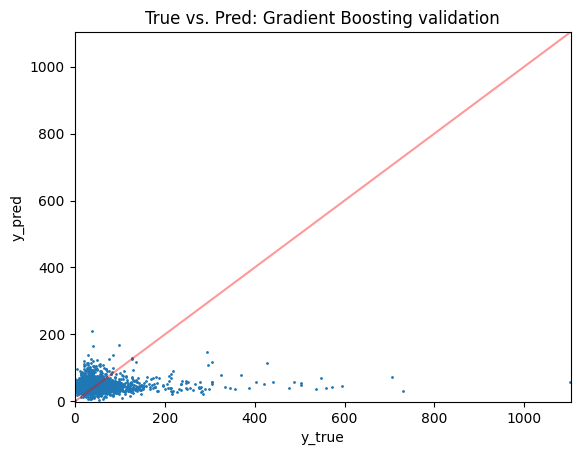

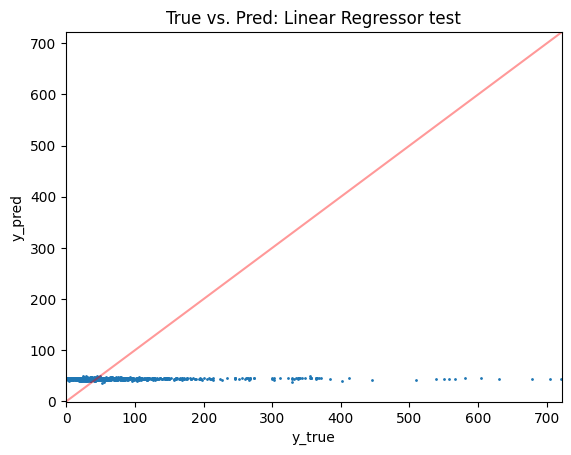

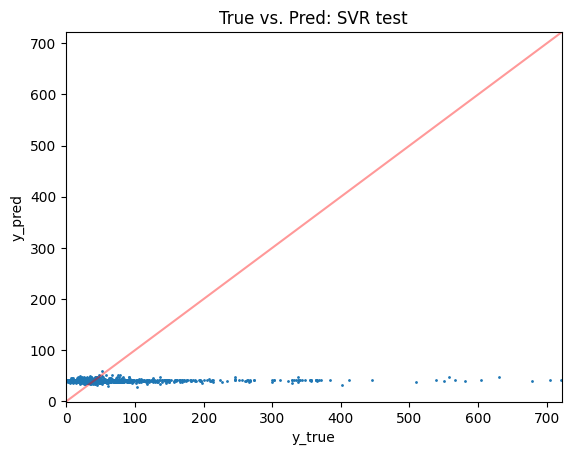

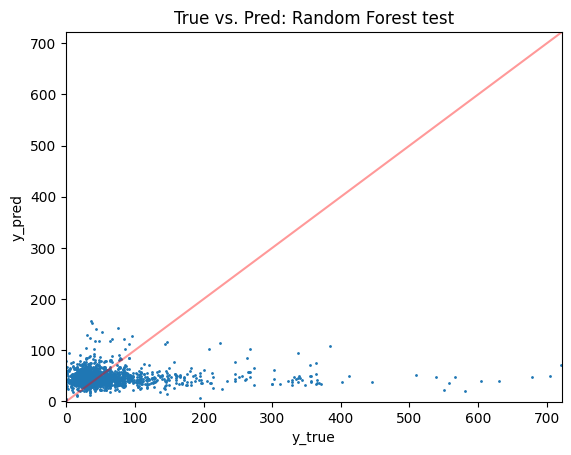

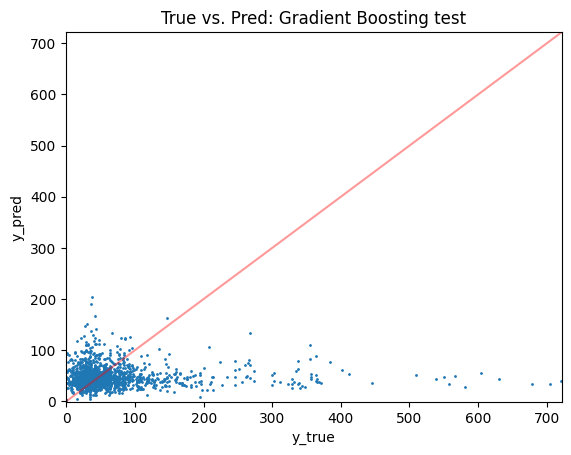

In [5]:
num_components = 40
for item in evaluation:
    for model_name, model_instance in MLA:
        plot.predicitons_scatter(selection_methode, all_predictions[num_components][model_name], evaluation=item,name=(str(num_components)+"_PCA_"),y_true_max=None, s=1)

## Histogramm Residuen

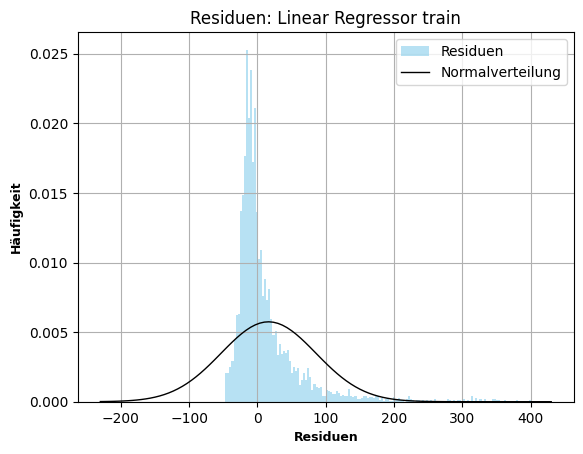

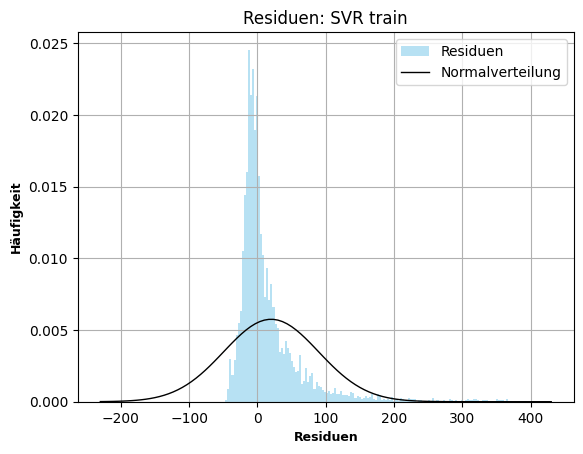

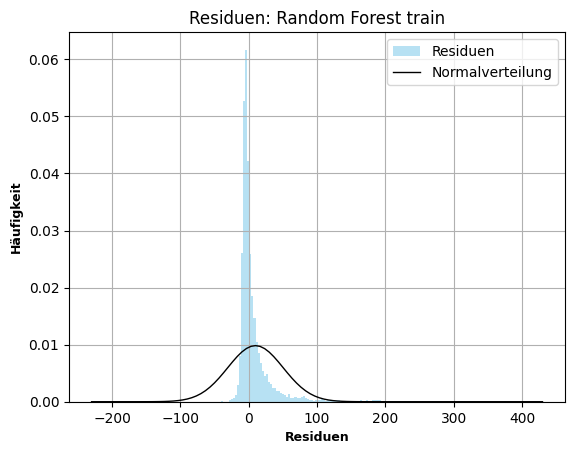

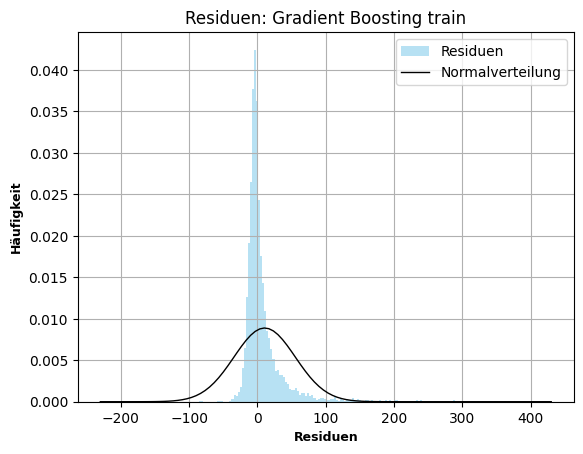

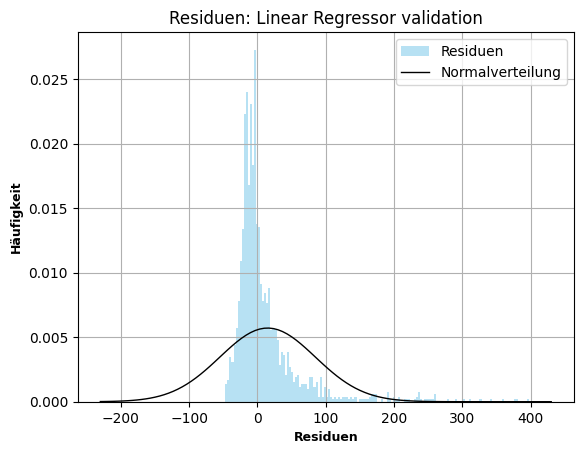

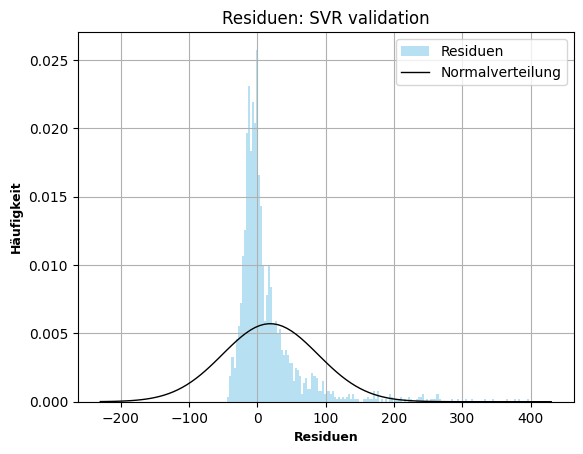

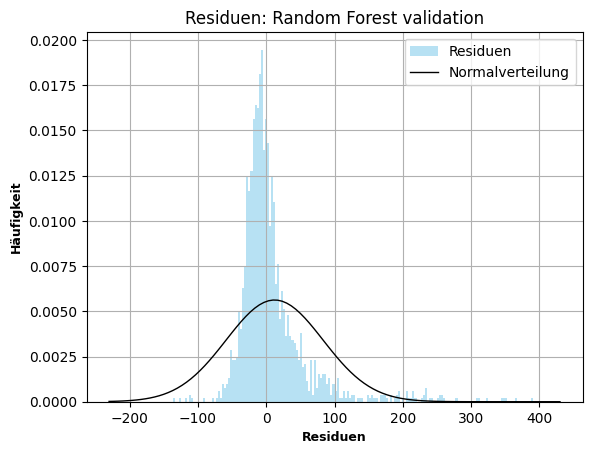

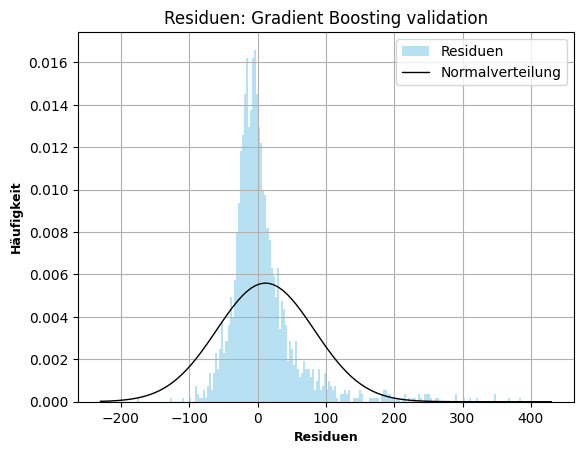

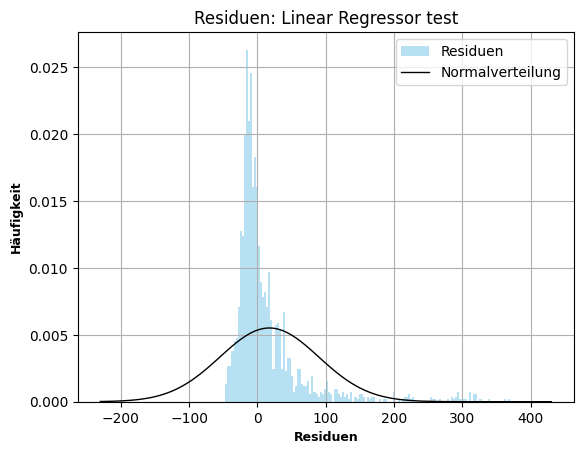

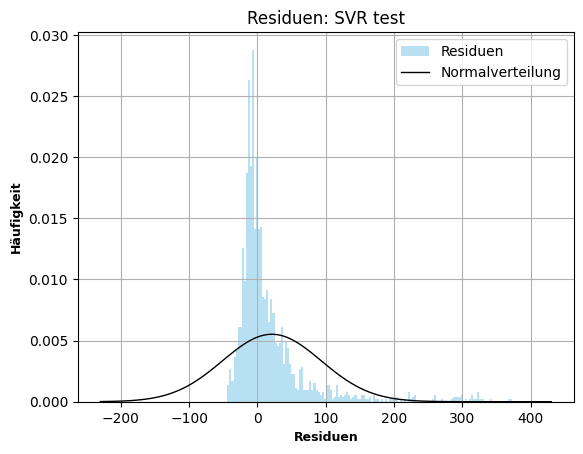

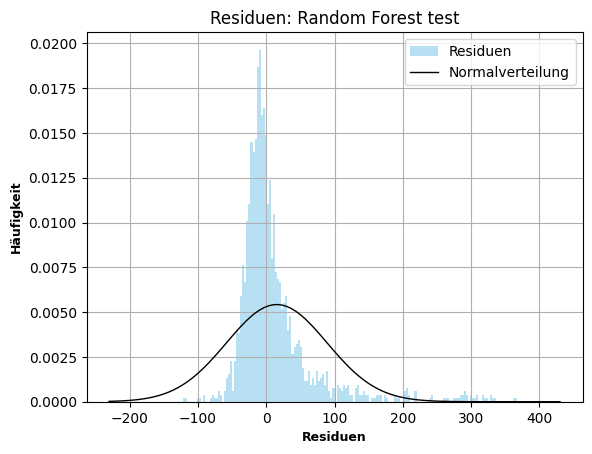

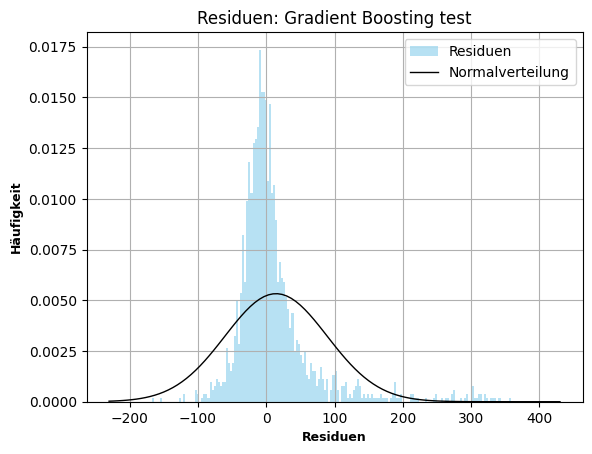

In [6]:
num_components = 10
for item in evaluation:
    for model_name, model_instance in MLA:
        plot.residuen_histo(selection_methode, all_predictions[num_components][model_name], evaluation=item, name= (str(num_components)+"_PCA_"), range_min=-200, range_max=400)

## Barplots Metrics

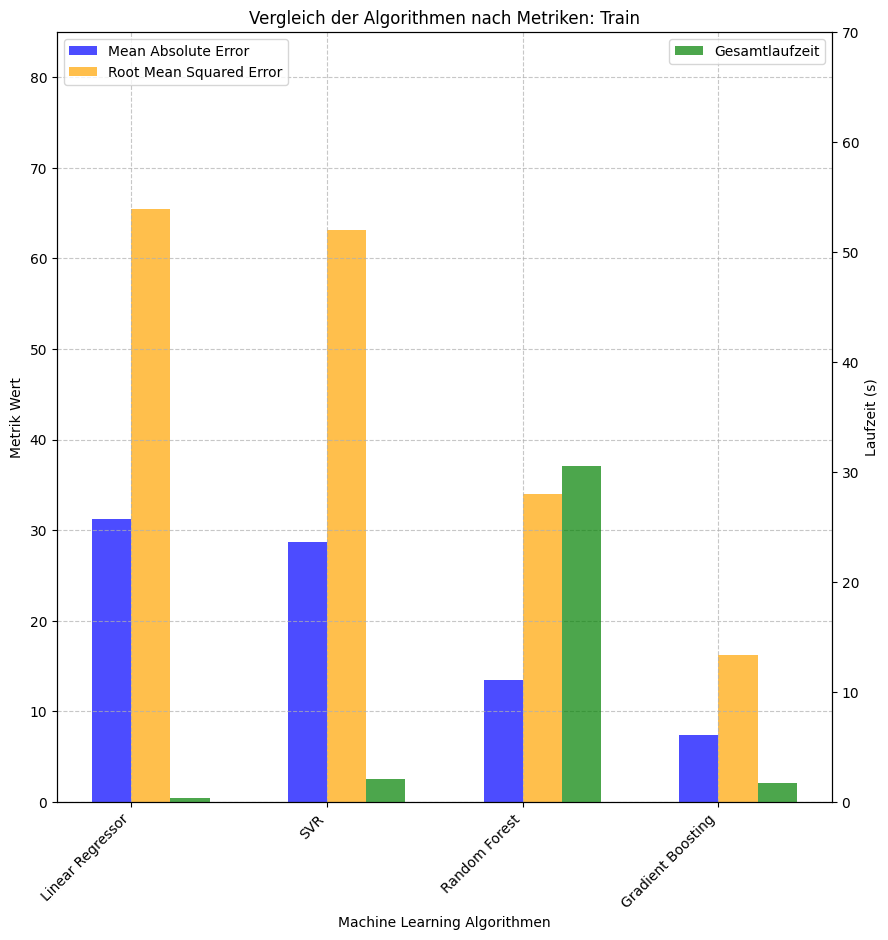

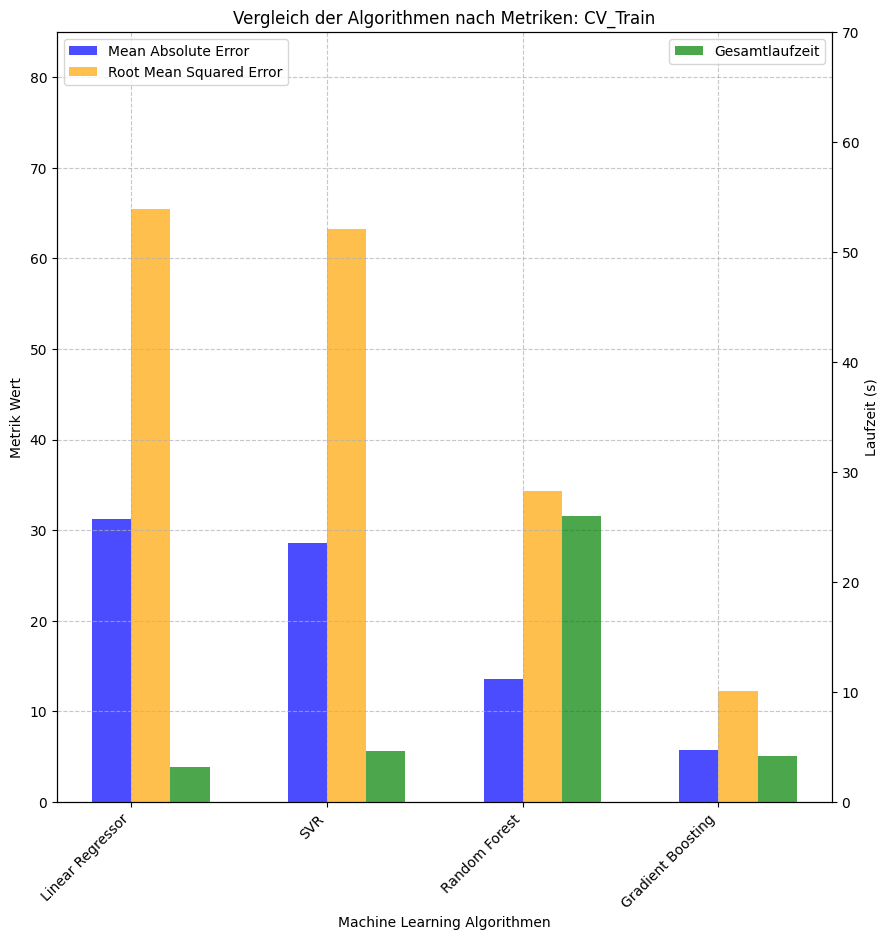

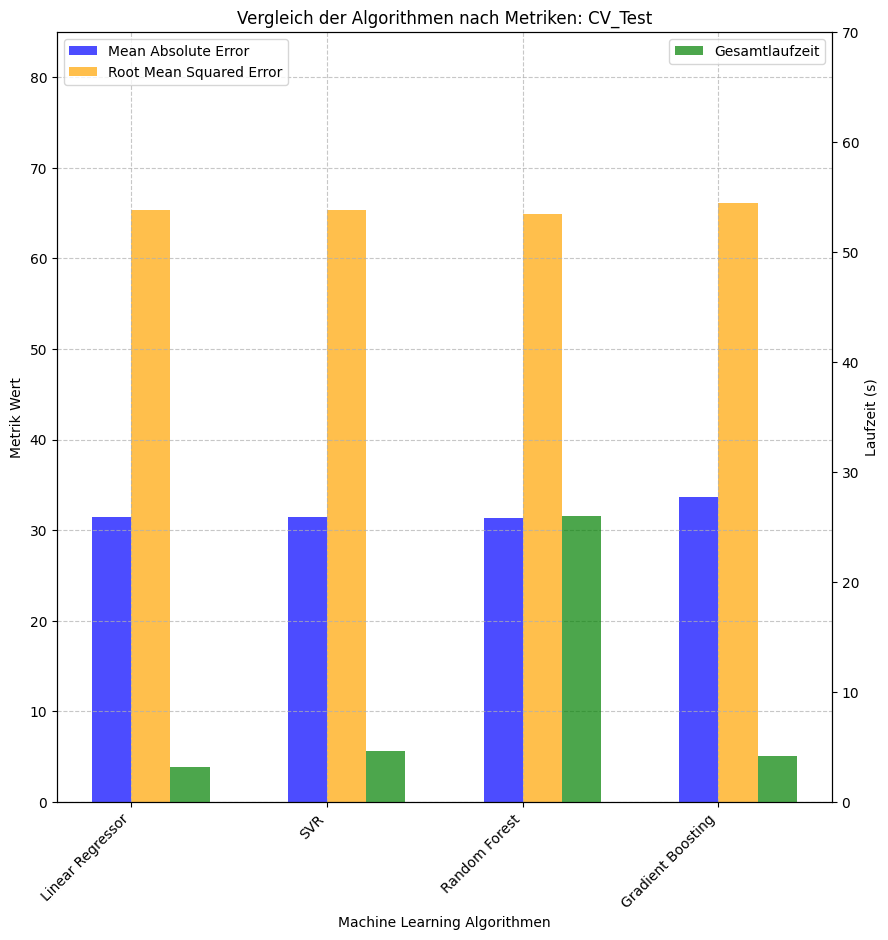

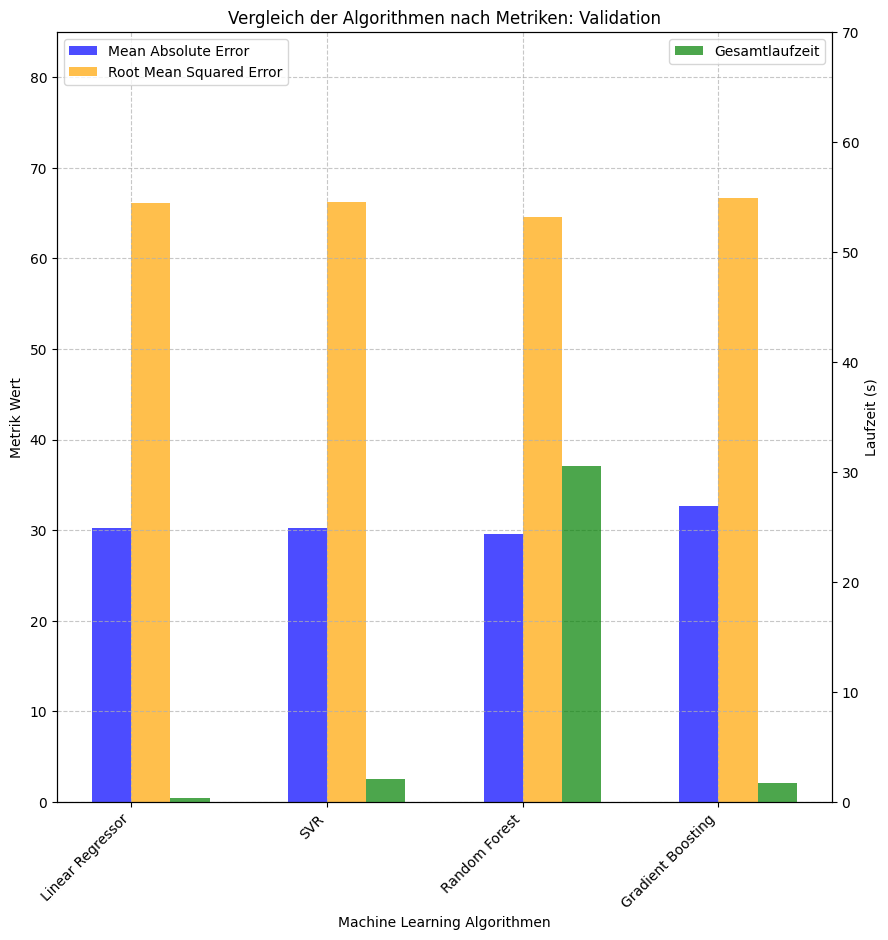

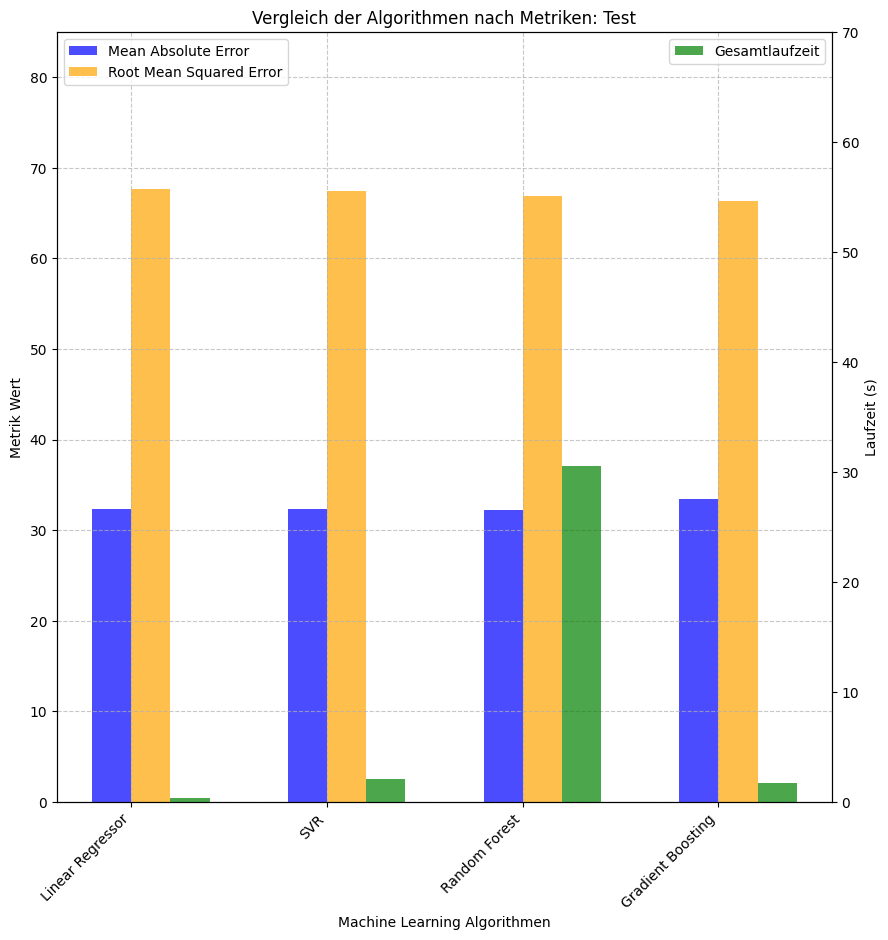

In [5]:
num_components = 40
for item in evaluation:
    plot.model_results_barplot(selection_methode, all_results[num_components], metrics_upper_limit=85, runtime_upper_limit=70, plot_runtime=True, evaluation=item,name= (str(num_components) +"_PCA_"))